# Random Walk Performance
# Skip notebook test¶ 

Random walk performance is governed by the length of the paths to find and the number of seedsthe size or structure of the graph.  Because of that, this benchmark uses just a single test graph

In [1]:
#  Import the modules
import cugraph
import cudf

In [2]:
# system and other
import gc
import os
import time
import random

In [3]:
try: 
    import matplotlib
except ModuleNotFoundError:
    os.system('pip install matplotlib')

import matplotlib.pyplot as plt; plt.rcdefaults()


## Read the data and create a graph

In [4]:
# Read The Data
# Define the path to the test data  
datafile='../data/email-Eu-core.csv'
gdf = cudf.read_csv(datafile, delimiter=' ', names=['src', 'dst', 'wt'], dtype=['int32', 'int32', 'float'] )

In [5]:
# Create a Graph - using the source (src) and destination (dst) vertex pairs from the Dataframe 
G = cugraph.Graph()
G.from_cudf_edgelist(gdf, source='src', destination='dst', edge_attr='wt')
(G.number_of_nodes(), G.number_of_edges() )

(1005, 16706)

In [6]:
num_nodes = G.number_of_nodes()

### Define the call to RandonWalk
we are only interested in the runtime, so throw away the results

In [7]:
def run_rw(_G, _seeds, _depth):
    t1 = time.time()
    _, _ = cugraph.random_walks(_G, _seeds, _depth)
    t2 = time.time() - t1
    return t2

## Test 1: Runtime versus path depth

In [8]:
# some parameters
max_depth = 6
max_seeds = 10

In [9]:
# array to capture runtime
runtime_depth = [None] * (max_depth - 1)

In [10]:
for i in range (2, max_depth+1) :
    seeds = random.sample(range(num_nodes), max_seeds)
    #print(f"{i} - {seeds}")
    runtime_depth[i -2] = run_rw(G, seeds, i)

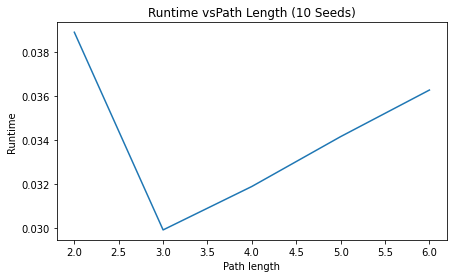

In [11]:
%matplotlib inline
seed_idx = list(range(2,max_depth +1))

plt.figure(figsize=(7,4))
plt.plot(seed_idx, runtime_depth)
plt.title('Runtime vsPath Length (10 Seeds)')
plt.xlabel('Path length')
plt.ylabel('Runtime')

plt.show()

## Test 2: Runtime versus number of seeds

In [12]:
# some parameters
rw_depth = 4
max_seeds = 100

In [13]:
# array to capture runtime
runtime = [None] * max_seeds

In [14]:
for i in range (max_seeds) :
    seeds = random.sample(range(num_nodes), i+1)
    runtime[i] = run_rw(G, seeds, rw_depth)

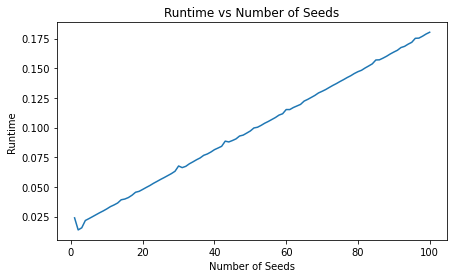

In [21]:
%matplotlib inline
seed_idx = list(range(1,max_seeds +1))


plt.figure(figsize=(7,4))
plt.plot(seed_idx, runtime)
plt.title('Runtime vs Number of Seeds')
plt.xlabel('Number of Seeds')
plt.ylabel('Runtime')
plt.show()

In [16]:
# uncomment the next line if you want to dump runtimes
# runtime

## Test 3: Multi-seed versus Sequencial

In [17]:
runtime_seq = [0] * max_seeds

In [18]:
for i in range (max_seeds) :
    for j in range(i):
        seeds = random.sample(range(num_nodes), 1)
        t = run_rw(G, seeds, rw_depth)
        runtime_seq[i] = runtime_seq[i] + t

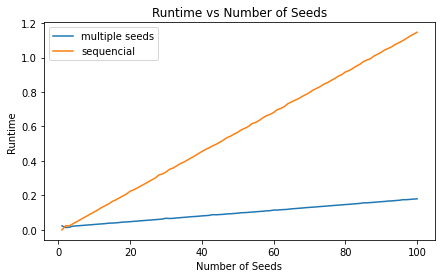

In [20]:
%matplotlib inline
seed_idx = list(range(1,max_seeds +1))


plt.figure(figsize=(7,4))
plt.plot(seed_idx, runtime, label = "multiple seeds")
plt.plot(seed_idx, runtime_seq, label = "sequencial")


plt.title('Runtime vs Number of Seeds')
plt.xlabel('Number of Seeds')
plt.ylabel('Runtime')
plt.legend()
plt.show()

-----
Copyright (c) 2021, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.